<a href="https://colab.research.google.com/github/jbcgames/Laboratorio_1_Procesamiento/blob/main/Proyecto_Sincronizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tx a 24khz cuadrada
- portadora a 4mhz y copia a desface de 180°
- selector 1 0° 0 180°
- Aplicar canal
- multiplicar por 4mhz señal en el canal
- comparar

# Generacion Codificacion

In [347]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import square
from collections import Counter
import heapq
from itertools import count

class _Node:
    __slots__ = ("freq", "char", "left", "right")
    def __init__(self, freq, char=None, left=None, right=None):
        self.freq = freq
        self.char = char
        self.left = left
        self.right = right

def _build_huffman_tree(message: str) -> _Node:
    """
    Construye el árbol de Huffman para el mensaje.
    Maneja el caso borde de un único símbolo en el mensaje.
    """
    if not message:
        raise ValueError("El mensaje no puede ser vacío.")

    freq = Counter(message)
    pq, tie = [], count() # generador de orden para desempates
    for ch, f in freq.items():
        # (frecuencia, orden, nodo)
        heapq.heappush(pq, (f, next(tie), _Node(f, char=ch)))

    # Caso especial: solo un símbolo -> crea un árbol con un hijo
    if len(pq) == 1:
        f, _, node = heapq.heappop(pq)
        root = _Node(f, left=node, right=None)
        return root

    while len(pq) > 1:
        f1, _, n1 = heapq.heappop(pq)
        f2, _, n2 = heapq.heappop(pq)
        parent = _Node(f1 + f2, left=n1, right=n2)
        heapq.heappush(pq, (parent.freq, next(tie), parent))

    return heapq.heappop(pq)[2]

def _build_codes(root: _Node) -> dict:
    """
    Recorre el árbol y genera el diccionario {caracter: código_en_bits}.
    """
    codes = {}

    def dfs(node, path):
        if node.char is not None:          # hoja
            codes[node.char] = path or "0" # si hay un solo símbolo, asígnale "0"
            return
        if node.left:
            dfs(node.left, path + "0")
        if node.right:
            dfs(node.right, path + "1")

    dfs(root, "")
    return codes

def huffman_encode(message: str):
    """
    Codifica `message` con Huffman.
    Returns:
        bits: str  -> secuencia de '0' y '1'
        codes: dict -> mapa {caracter: código}
    """
    root = _build_huffman_tree(message)
    codes = _build_codes(root)
    bits = "".join(codes[ch] for ch in message)
    return bits, codes

def huffman_decode(bits: str, codes: dict) -> str:
    """
    Decodifica la secuencia de bits usando el diccionario de códigos.
    """
    if not bits and codes:
        return ""  # nada que decodificar

    inv = {code: ch for ch, code in codes.items()}

    out = []
    acc = ""
    for b in bits:
        acc += b
        if acc in inv:
            out.append(inv[acc])
            acc = ""
    if acc:
        raise ValueError("Bits sobrantes: el flujo de bits no coincide con los códigos.")
    return "".join(out)

msg = "Mensaje de prueba "
print(len(msg)*8)
bits, codes = huffman_encode(msg)
print("Bits:", bits)
print("Códigos:", codes)
print(len(bits))
print("Decodificado:", huffman_decode(bits[:len(bits)], codes))
# Agregar 3 bits adificonales en 1 para evitar errores en la decodificacion
bits += '111'
# Agregar 3 bits adicionales en 0 al inicion para sincronizacion
bits = '000' + bits
print("Bits con sincronizacion y relleno:", bits)



144
Bits: 0100000101011011110111001101000001101001101010110011101111110
Códigos: {'e': '00', 'M': '0100', 'n': '0101', 's': '0110', 'j': '0111', 'd': '1000', 'p': '1001', 'r': '1010', 'u': '1011', ' ': '110', 'b': '1110', 'a': '1111'}
61
Decodificado: Mensaje de prueba 
Bits con sincronizacion y relleno: 0000100000101011011110111001101000001101001101010110011101111110111


# Generacion Portadora

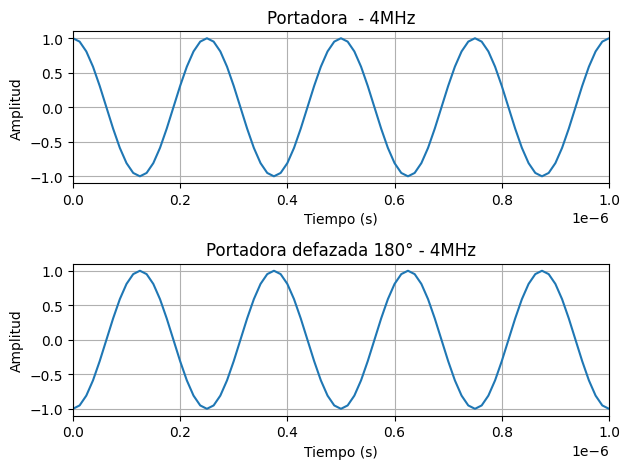

In [348]:
#generacion de senal de seno de 4mhz
import numpy
f_seno = 4e6
fs=80e6
f_datos = 24e3
A_seno = 1
t=numpy.arange(0, 1/f_datos*len(bits), 1/fs)  # Tiempo de 0 a 10us con fs=80MHz
def señal_cosenoidal(f, A=1, desface=0):
    x = A * numpy.cos(2 * numpy.pi * f * t + desface)
    return t, x
# Definir fs para coincidir con la informacion
t_1, X_Portadora1 = señal_cosenoidal(f_seno, A_seno)
t_2, X_Portadora2 = señal_cosenoidal(f_seno, A_seno, desface=numpy.pi) #desface de 180°
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_1, X_Portadora1)
ax1.set_title('Portadora  - 4MHz')
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Amplitud')
ax1.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t_2, X_Portadora2)
ax2.set_title('Portadora defazada 180° - 4MHz')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Amplitud')
ax2.grid()
plt.xlim(0, 0.000001)  # Ajustar el límite del eje x para ver mejor la señal
plt.tight_layout()
plt.show()

# Selector

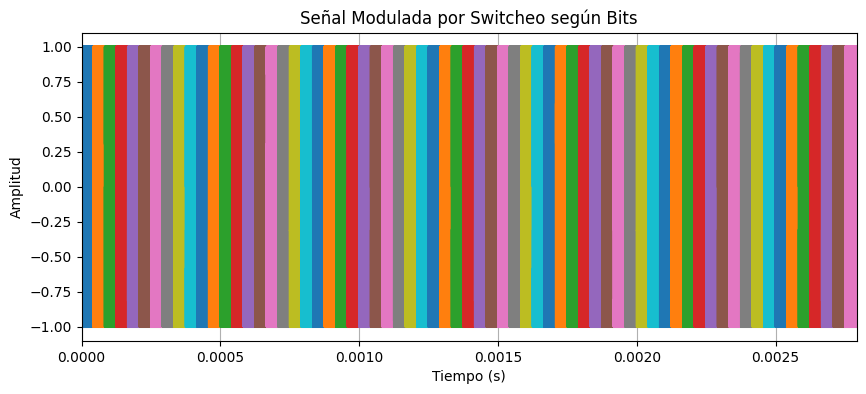

In [349]:
# si 1 entonces portadora 1
# si 0 entonces portadora 2
# Crear switche

def switcheo(bits, t, fs, f_seno, A_seno):
    señal_modulada = numpy.zeros_like(t)
    muestras_por_bit = int(fs / f_datos)
    #Graficar Mostrando cambios de fase segun bits
    plt.figure(figsize=(10, 4))
    for i, bit in enumerate(bits):
        inicio = i * muestras_por_bit
        fin = inicio + muestras_por_bit
        if bit == '1':
            _, portadora = señal_cosenoidal(f_seno, A_seno)
            plt.plot(t[inicio:fin], portadora[inicio:fin], label=f'Bit {bit} en {i}')
        else:
            _, portadora = señal_cosenoidal(f_seno, A_seno, desface=numpy.pi)
            plt.plot(t[inicio:fin], portadora[inicio:fin], label=f'Bit {bit} en {i}')
        señal_modulada[inicio:fin] = portadora[inicio:fin]
    plt.title('Señal Modulada por Switcheo según Bits')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid()
    plt.xlim(0, 1/f_datos*len(bits))  # Ajustar el límite del eje x para ver toda la señal
    plt.show()
    return señal_modulada
señal_modulada = switcheo(bits, t, fs, f_seno, A_seno)


# Crear Canal

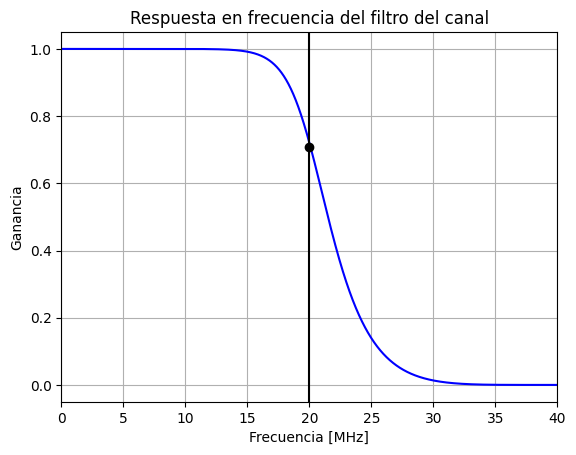

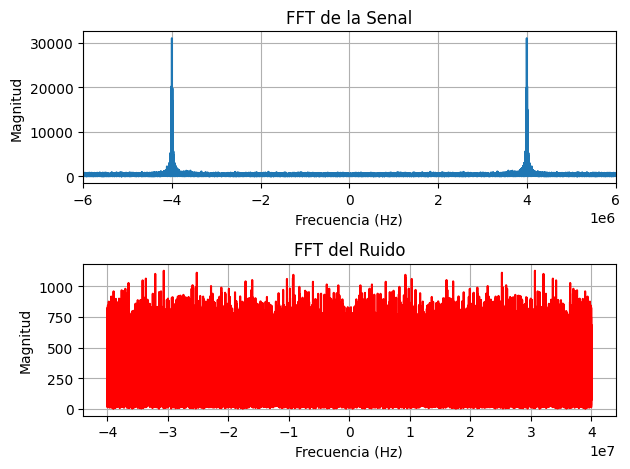

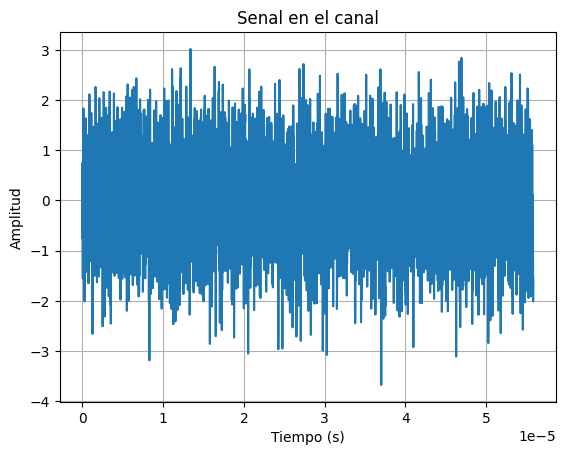

In [365]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter, freqz
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db, snr_db=20):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    # Simular respuesta natural del filtro del canal
    w, h = freqz(b, a, worN=100*32000)
    plt.figure()
    plt.plot((0.16*fs*numpy.pi*w/numpy.pi)/1e6, numpy.abs(h), 'b')
    plt.plot(fc/1e6, 0.5*numpy.sqrt(2), 'ko')
    plt.axvline(fc/1e6, color='k')
    plt.xlim(0, 0.5*fs/1e6)
    plt.title("Respuesta en frecuencia del filtro del canal")
    plt.xlabel('Frecuencia [MHz]')
    plt.ylabel('Ganancia')
    plt.grid()
    plt.show()

    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    x_ruidos = agregar_ruido_gaussiano(x_filtrada, snr_db)  # SNR de 20 dB
    atenuacion = 10 ** (atenuacion_db / 20)
    X_atenuada = x_ruidos * atenuacion

    return X_atenuada
# Adicion de ruido gaussiano
def agregar_ruido_gaussiano(x, snr_db):
    # Calcular potencia de la señal
    potencia_senal = numpy.mean(x**2)
    # Calcular potencia del ruido
    snr = 10 ** (snr_db / 10)
    potencia_ruido = potencia_senal / snr
    # Generar ruido gaussiano hasta 800 Mhz
    ruido = numpy.random.normal(0, numpy.sqrt(potencia_ruido), len(x))
    # Señal con ruido
    x_ruidosa = x + ruido
    #Graficacion FFT del Ruido
    f, X = aplicar_fft(x_ruidosa, fs)
    f_ruido, R = aplicar_fft(ruido, fs)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(f, numpy.abs(X), label='Senal')
    plt.title('FFT de la Senal')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    #plt.ylim(0, 500)
    plt.xlim(-6e6, 6e6)
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(f_ruido, numpy.abs(R), label='Ruido', color='red')
    plt.title('FFT del Ruido')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return x_ruidosa
# Prueba de canal
fc = 20e6
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(señal_modulada, fs, fc, atenuacion_db= 0 , snr_db=0)
t_canal = t
plt.figure()
longitud=int(len(t)/50)
tempo=625
plt.plot(t_canal[:longitud], x_canal[:longitud])
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()


# Detectar fase de la señal Mediante PLL

Desfase estimada (radianes): -2.087993168367989


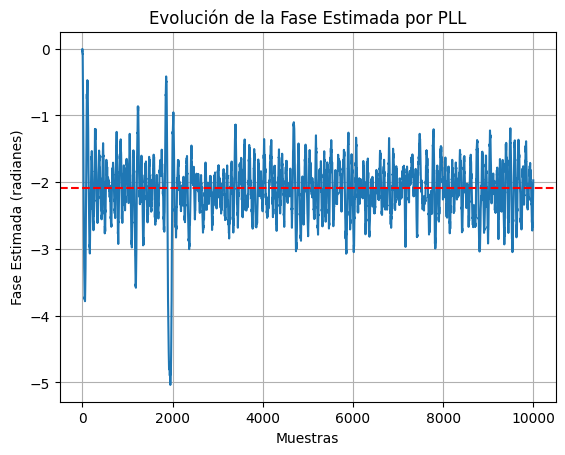

In [366]:
# Detectar fase mediante PLL

def detectar_fase_pll(signal, f_seno, fs, Kp=0.05, Ki=0.01, num_samples=10000):
    phase_estimate = 0
    integral = 0
    phases = []
    for n in range(num_samples):
        # Generar la señal local con la fase estimada
        local_oscillator = numpy.cos(2 * numpy.pi * f_seno * (n / fs) + phase_estimate)
        # Mezclar la señal recibida con el oscilador local
        error_signal = signal[n] * local_oscillator
        # Actualizar el integrador y la fase estimada
        integral += error_signal
        phase_estimate += Kp * error_signal + Ki * integral
        phases.append(phase_estimate)
    return phases
phases = detectar_fase_pll(x_canal, f_seno, fs)
Desface_estimado = numpy.mean(phases[-1000:])
print("Desfase estimada (radianes):", Desface_estimado)
plt.figure()
plt.plot(phases)
# Graficar el promedio de las ultimas mil muestras
plt.axhline(y=Desface_estimado, color='r', linestyle='--', label='Desfase Estimado Promedio')
plt.title('Evolución de la Fase Estimada por PLL')
plt.xlabel('Muestras')
plt.ylabel('Fase Estimada (radianes)')
plt.grid()
plt.show()

# Desfase estimada a partir del promedio de las ultimas mil muestras

# Crear señal reconstruida con fase estimada
t_reconstruida, x_reconstruida = señal_cosenoidal(f_seno, A_seno, desface=phases[-1])

# Multiplicacion por 4MHZ

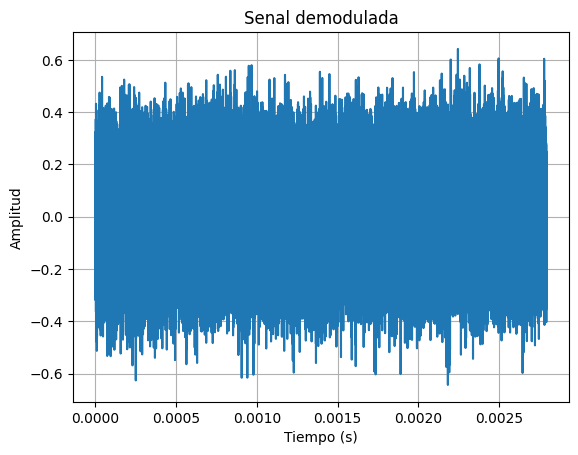

In [367]:
#Normalizacion de la señal recibida
X_canal = x_canal / numpy.max(numpy.abs(x_canal))

X_demodulada = X_canal * x_reconstruida
# Graficar la señal demodulada
plt.figure()
plt.plot(t_canal, X_demodulada, label='Senal demodulada')
plt.title('Senal demodulada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# Integrar para detectar bits

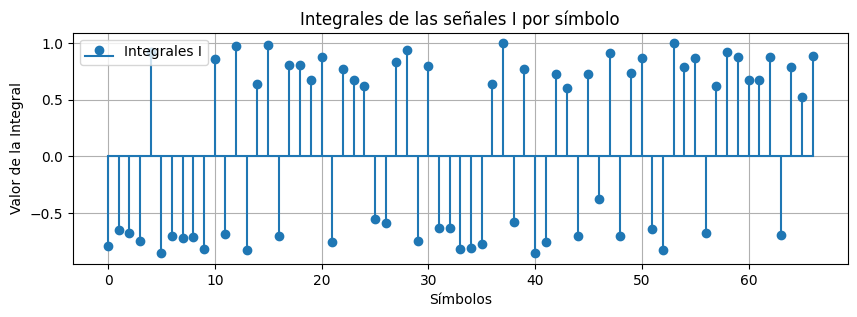

In [368]:
# Integrar para detectar bits
# Integrar cada señal desde 0 hasta la duración de cada símbolo
# Integrar para detectar bits
# Integrar cada símbolo (bit) usando muestras_por_bit
muestras_por_bit = int(fs / f_datos)
integral_I = []
num_bits = len(bits)
for i in range(num_bits):
    start = i * muestras_por_bit
    end = start + muestras_por_bit
    if end > len(X_demodulada):
        break
    integral = np.trapezoid(X_demodulada[start:end], dx=1/fs)
    integral_I.append(integral)
# Normalizar a 1 -1
if integral_I:
    max_I = max(abs(min(integral_I)), abs(max(integral_I)))
    if max_I != 0:
        integral_I = [i / max_I for i in integral_I]
    else:
        integral_I = [0 for _ in integral_I]
# Graficar las integrales obtenidas
plt.figure(figsize=(10, 3))
plt.stem(range(len(integral_I)), integral_I, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label='Integrales I')

plt.xlabel('Símbolos')
plt.ylabel('Valor de la Integral')
plt.title('Integrales de las señales I por símbolo')
plt.legend()
plt.grid(True)
plt.show()

# Crear Decodificacion

In [369]:
# Decodificar la señal y devolver los bits
bits_decodificados = []
for valor in integral_I:
    if valor > 0:
        bits_decodificados.append('0')
    else:
        bits_decodificados.append('1')

# Calcular tasa de error de bits (BER)
error_count = 0
invertir = False
Correcto = False
for i in range(min(len(bits), len(bits_decodificados))):
    Correcto = True
    if bits[i] != bits_decodificados[i]:
        Correcto = False
        invertir = True
        break
    
# Intentar invertir los bits decodificados si se detecta un error
if invertir:
    bits_decodificados = ['1' if b == '0' else '0' for b in bits_decodificados]

for i in range(min(len(bits), len(bits_decodificados))):
    if bits[i] != bits_decodificados[i]:
        invertir = False
        # no hay error de fase
        break
# Detectar los errores
if invertir == False and Correcto == False:
    bits_decodificados = ['1' if b == '0' else '0' for b in bits_decodificados]

for i in range(min(len(bits), len(bits_decodificados))):
    if bits[i] != bits_decodificados[i]:
        error_count += 1
        print(f"Error en bit {i}: original={bits[i]}, decodificado={bits_decodificados[i]}")
# Mostrar bits decodificados
print("Bits decodificados:", ''.join(bits_decodificados))
# COmparar con los bits originales
print("Bits originales   :", bits[:len(bits_decodificados)])
if error_count == 0:
    print("Todos los bits decodificados coinciden con los originales.")
else:
    print(f"Total de bits con error: {error_count} de {min(len(bits), len(bits_decodificados))}")
    


Bits decodificados: 0000100000101011011110111001101000001101001101010110011101111110111
Bits originales   : 0000100000101011011110111001101000001101001101010110011101111110111
Todos los bits decodificados coinciden con los originales.


# Decodificar en Huffman


In [370]:
# Decodificar en Huffman
print(bits_decodificados[3:len(bits)-3])
# Ignorar los bits adicionales agregados
mensaje_decodificado = huffman_decode(bits_decodificados[3:len(bits)-3], codes)
print("Mensaje Decodificado:", mensaje_decodificado)


['0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0']
Mensaje Decodificado: Mensaje de prueba 
